In [1]:
import numpy as np
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import math
from scipy import stats
import glob
from scipy.interpolate import interp1d
import mplcursors
%matplotlib inline
from matplotlib.widgets import Slider, Button, RadioButtons
from ipywidgets import interact #, interactive, fixed, interact_manual
#import ipywidgets as widgets

So we saw in the 5-30-19 that we couldn't get dlog(V)/dlog(R) to be the desired -0.5. What I'm doing in this is going back to change the ML_bulge and ML_disk linearly. To do so, I'm going to re-find Vp, bary and use my own velocity values instead of Starkman.

instead of interpolating, will just choose max points as Vp_bary, Vp_obs

In [2]:
ML_disk, ML_bulge, DM_frac, SB_bary,  Ltot, HImass, Vflat, index_stop = np.loadtxt('data for good galaxies.csv', delimiter=',', skiprows = 1, usecols = (1,2,3,5,14,20,22,24),unpack = True)
Lbulge  = np.loadtxt('sparc global measurements.csv', delimiter=',', unpack = True, skiprows = 2, usecols = (20)) 
sparc = np.load('sparc_dict.npy').item()
name = np.loadtxt('starkman data.csv', delimiter=',', skiprows = 2, usecols = (0), dtype = 'object', unpack = True)
rad_start, rad_stop = np.loadtxt('bracketing curves.csv', delimiter=',', skiprows = 1, usecols = (3,4),unpack = True)

Ltot, Lbulge, HImass = Ltot*1e9, Lbulge*1e9, HImass*1e9


In [3]:
len_tot = 116
Rp_arr = np.empty(len_tot) #stores Rp
DM_frac = np.empty(len_tot) #stores fraction of galaxies which are DM by mass
SB_bary = np.empty(len_tot) #stores baryonic surface brightness
Mbary_arr  = np.empty(len_tot) #stores baryonic mass of galaxy
ML_disk  = np.full(len_tot, 0.5)
ML_bulge  = np.full(len_tot, 0.7)
Vp_baryarr = np.empty(len_tot) #stores Vp of baryonic rotation curve
Vp_obsarr = np.empty(len_tot) #stores Vp of observed rotation curve
index_stoparr = np.empty(len_tot) #stores the array index of Rp
index_peakarr = np.empty(len_tot) #stores the array index of the upper bracket for finding Rp

In [4]:
def interpolation(gal_name, mult_factor, start, stop):
    ML_disknew, ML_bulgenew = 0.5*mult_factor, 0.7*mult_factor
   
    vbary = np.sqrt(ML_disknew * sparc[gal_name+"_Vdisk"]**2 + ML_bulgenew * sparc[gal_name+"_Vbul"]**2 + sparc[gal_name+"_Vgas"]**2 )

    interp_vobs = interp.UnivariateSpline(sparc[gal_name+"_rad"], sparc[gal_name+'_Vobs'])
    radius_vals = np.linspace(sparc[gal_name+"_rad"].min(), sparc[gal_name+"_rad"].max(), 1000)
    interp_vbary = interp.UnivariateSpline(sparc[gal_name+"_rad"], vbary)
    
    index_start =np.argmin(np.abs(start - radius_vals))
    index_stop = np.argmin(np.abs(stop - radius_vals))
    interp_vbaryderiv = interp_vbary(radius_vals, nu=1)
    index_peak = index_start + np.argmax(interp_vbary(radius_vals)[index_start:index_stop])#np.argmin(np.abs(interp_vbaryderiv))#
    
    Rp = radius_vals[index_peak]
    Rp_arr[sparc[gal_name+"_index"]] = Rp
    Vp_bary = interp_vbary(Rp)
    Vp_obs = interp_vobs(Rp)
    
    DM_frac[sparc[gal_name+"_index"]] = (Vp_obs - Vp_bary)/Vp_obs
    SB_bary[sparc[gal_name+"_index"]]  = (3/4) * (Mbary_arr[sparc[gal_name+"_index"]]/Rp**2)#
    Vp_baryarr[sparc[gal_name+"_index"]] = Vp_bary
    Vp_obsarr[sparc[gal_name+"_index"]] = Vp_obs
    index_peakarr[sparc[gal_name+"_index"]] = index_peak
    index_stoparr[sparc[gal_name+"_index"]] = index_stop
        

In [5]:
def ML_linear(mult_factor):
    ML_disknew = 0.5 * mult_factor
    ML_bulgenew = 0.7 * mult_factor

    lum_orig = Ltot #using original M/L
    Lgas = HImass * (1/1.33)
    Lbulgenew = Lbulge*(ML_bulge/ML_bulgenew)
    Ldisknew = (Ltot - Lbulge - Lgas)*(ML_disk/ML_disknew)
    lum_new = Lgas + Ldisknew + Lbulgenew #using new M/L with changes applied
    #print(Ltot - Lbulgenew - Lgasnew)

    ##Vobs
    coeff,cov=np.polyfit(np.log10(lum_new), np.log10(Vp_obsarr),1,cov=True) #creating best-fit line from modified data
    coeff_err = np.sqrt(np.diag(cov))
    xfit=np.linspace(min(np.log10(lum_orig)),max(np.log10(lum_orig)),1000)
    polynomial=np.poly1d(coeff)

    delt_Vnew = np.log10(Vp_obsarr) - (coeff[0]*np.log10(lum_orig) + coeff[1]) #delt_v = Vp_obs - (mx+b) where m,b solved in best fit line

    ## Rp
    coeff,cov=np.polyfit(np.log10(lum_new), np.log10(Rp_arr),1,cov=True) #creating best-fit line from modified data
    coeff_err = np.sqrt(np.diag(cov))
    xfit=np.linspace(min(np.log10(lum_orig)),max(np.log10(lum_orig)),1000)
    polynomial=np.poly1d(coeff)

    delt_Rnew = np.log10(Rp_arr) - (coeff[0]*np.log10(lum_orig) + coeff[1])
    
    
    plt.figure(figsize=(12,10))
    
    goodvals = np.where((Vp_obsarr > Vp_baryarr) & (index_peakarr < index_stoparr))
    plt.scatter(delt_Rnew[goodvals], delt_Vnew[goodvals], c =DM_frac[goodvals], cmap=plt.cm.get_cmap('plasma_r'))
    plt.colorbar().set_label("DM fraction")
    plt.axis('equal')
    plt.xlabel('d log(Rp)', fontsize = 'large')
    plt.ylabel('d log(V)', fontsize = 'large')

    coeff,cov=np.polyfit(delt_Rnew[goodvals], delt_Vnew[goodvals],1,cov=True)
    coeff_err = np.sqrt(np.diag(cov))
    xfit=np.linspace(min(delt_Rnew[goodvals]),max(delt_Rnew[goodvals]),1000)
    polynomial=np.poly1d(coeff)
    plt.plot(xfit,polynomial(xfit),color='green')
    print('    slope = {:.6f} +/- {:.3f}'.format(coeff[0],coeff_err[0]))

    plt.plot(xfit, xfit*-.5, ls = ':')
    plt.axhline(ls = ':')
    #print('    mean dV/dR = {:.3f}'.format(np.mean(delt_Vnew / delt_Rnew)))

                                                                              
                                                                              

In [14]:
# def dVdR():
#     for x in range(len(name)):
#          interpolation(name[x], np.exp(-2/(1*Rp_arr[x])), rad_start[x], rad_stop[x])
#     ML_linear(np.exp(-2/(1*Rp_arr)))
# dVdR()
# import numpy as np
# import scipy.interpolate as interp
# import matplotlib.pyplot as plt
# import math
# from scipy import stats
# import glob
# from scipy.interpolate import interp1d
# import mplcursors
# %matplotlib inline
# from matplotlib.widgets import Slider, Button, RadioButtons
# from ipywidgets import interact #, interactive, fixed, interact_manual
# #import ipywidgets as widgets


# name = np.loadtxt('starkman data.csv', delimiter=',', skiprows = 2, usecols = (0), dtype = 'object', unpack = True)
# rad_start, rad_stop = np.loadtxt('bracketing curves.csv', delimiter=',', skiprows = 1, usecols = (3,4),unpack = True)
# ML_disk, ML_bulge, DM_frac, SB_bary,  Ltot, HImass, Vflat, index_stop = np.loadtxt('data for good galaxies.csv', delimiter=',', skiprows = 1, usecols = (1,2,3,5,14,20,22,24),unpack = True)
# Lbulge  = np.loadtxt('sparc global measurements.csv', delimiter=',', unpack = True, skiprows = 2, usecols = (20)) 
# sparc = np.load('sparc_dict.npy', allow_pickle=True).item()

def dVdR(mult_factor):
    for x in range(len(name)):
        interpolation(name[x], mult_factor, rad_start[x], rad_stop[x])
    ML_linear(mult_factor)

# options = {
#     'xlim': (-1.5, 1),
#     'ylim': (-1, 1.25),
# }

# from ipywidgets import interact #, interactive, fixed, interact_manual

#interact(dVdR, mult_factor=(0,3, .01)) 
#options = options,

In [15]:
#https://juliafalcone.github.io/CourteauRix/6-3-19%20linearly%20varying%20ML%20ratio.html

In [16]:
#nbi:hide_in

    slope = -0.002502 +/- 0.045


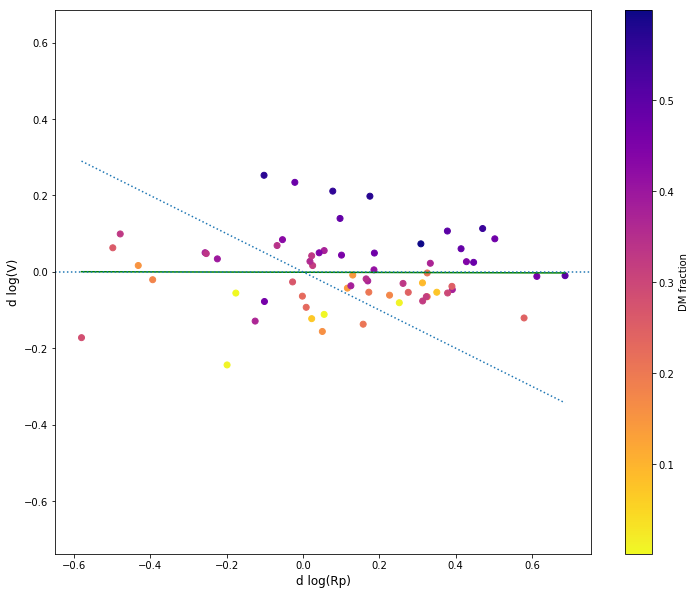

In [17]:
dVdR(2)